In [98]:
# upload image zip
from google.colab import files
uploaded = files.upload()


Saving images.zip to images.zip


In [99]:
import os
import numpy as np
import json
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2

import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

%pip install pillow_heif
import pillow_heif


In [100]:
# Unzip the file
import zipfile
import io

for fname in uploaded.keys():
    if fname.endswith(".zip"):
        zip_ref = zipfile.ZipFile(io.BytesIO(uploaded[fname]), 'r')
        zip_ref.extractall()
        zip_ref.close()


In [101]:
BATCH_SIZE = 32  # images to process at a time
IMG_HEIGHT = 224 # Standard input size for MobileNetV2
IMG_WIDTH = 224
DATA_DIR = os.path.join("/content/images")

In [102]:
# Remove the .DS_Store file if it exists
ds_store_path = os.path.join(DATA_DIR, '.DS_Store')
if os.path.exists(ds_store_path):
    os.remove(ds_store_path)
    print(f"Removed: {ds_store_path}")

print("Directory cleanup complete.")

Removed: /content/images/.DS_Store
Directory cleanup complete.


In [103]:
os.listdir(DATA_DIR)

['mathias', 'Souvede', 'Pretty', 'James', 'unknown']

In [104]:
import os
from PIL import Image
import pillow_heif

# register HEIF support
pillow_heif.register_heif_opener()

import os
from PIL import Image
import pillow_heif

pillow_heif.register_heif_opener()

def convert_heic_to_jpg(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            path = os.path.join(root, file)

            # Try reading as HEIC (even if extension lies)
            try:
                heif_file = pillow_heif.read_heif(path)
                # If no exception → it's a HEIC file
                image = heif_file.to_pillow()
                jpg_path = os.path.splitext(path)[0] + ".jpg"

                image.convert("RGB").save(jpg_path, "JPEG", quality=95)
                os.remove(path)

                print(f"Converted (content-detected) {path} → {jpg_path}")

            except Exception:
                # Not HEIC → ignore
                pass



In [105]:
convert_heic_to_jpg(DATA_DIR)

Converted (content-detected) /content/images/Pretty/pretty_5 copy 2.png → /content/images/Pretty/pretty_5 copy 2.jpg
Converted (content-detected) /content/images/Pretty/pretty_5 copy.png → /content/images/Pretty/pretty_5 copy.jpg
Converted (content-detected) /content/images/Pretty/pretty_1 copy.png → /content/images/Pretty/pretty_1 copy.jpg
Converted (content-detected) /content/images/Pretty/pretty_4.png → /content/images/Pretty/pretty_4.jpg
Converted (content-detected) /content/images/Pretty/pretty_2 copy.png → /content/images/Pretty/pretty_2 copy.jpg
Converted (content-detected) /content/images/Pretty/pretty_3 copy 4.png → /content/images/Pretty/pretty_3 copy 4.jpg
Converted (content-detected) /content/images/Pretty/pretty_4 copy 2.png → /content/images/Pretty/pretty_4 copy 2.jpg
Converted (content-detected) /content/images/Pretty/pretty_1 copy 2.png → /content/images/Pretty/pretty_1 copy 2.jpg
Converted (content-detected) /content/images/Pretty/pretty_2.png → /content/images/Pretty/

In [106]:
# Data spliting
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,  # Use 20% of the images for validation
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)


Found 89 files belonging to 5 classes.
Using 72 files for training.
Found 89 files belonging to 5 classes.
Using 17 files for validation.


In [107]:
# Load base model without classification layer
model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

/tmp/ipython-input-715086027.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


In [108]:
def extract_image_embedding(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    embedding = model.predict(img_array)
    return embedding.flatten()

In [90]:
records = []

for root, dirs, files in os.walk(DATA_DIR):
    for f in files:
        if f.lower().endswith(("png", "jpg", "jpeg")):
            path = os.path.join(root, f)
            label = os.path.basename(root)
            emb = extract_image_embedding(path)

            record = {"filename": f, "label": label}
            # convert embedding array to many columns
            for i, val in enumerate(emb):
                record[f"feat_{i}"] = val

            records.append(record)

df_img = pd.DataFrame(records)
df_img.to_csv("image_features.csv", index=False)
df_img.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━

,filename,label,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_1270,feat_1271,feat_1272,feat_1273,feat_1274,feat_1275,feat_1276,feat_1277,feat_1278,feat_1279
0,image19.jpeg,mathias,0.234842,1.859192,0.146330,2.322671,0.000000,0.143495,0.519587,2.194104,...,1.683195,0.814282,2.419621,1.904861,0.057979,1.218972,0.184635,0.981620,1.273651,2.110826
1,image13.jpeg,mathias,0.113731,0.177902,0.044857,0.209006,0.030622,0.285606,0.200203,0.830660,...,1.374302,0.649620,1.498995,0.564299,0.000000,0.218862,0.149089,0.444319,0.332013,1.074612
2,image9.jpeg,mathias,0.094265,0.893363,0.004679,0.544233,0.000000,0.552200,0.101712,0.721887,...,0.671116,2.490582,2.083554,0.370299,0.136306,0.374511,0.000000,0.257485,0.289594,1.593950
3,image5.jpeg,mathias,0.285245,0.578094,0.163512,0.766907,0.000000,1.919176,0.143657,0.568111,...,1.412180,0.576947,2.200048,1.481341,0.006286,2.246594,0.000700,0.597684,0.226439,1.894679
4,image16.jpeg,mathias,0.020515,0.470710,0.000000,1.253424,0.000000,0.350553,0.305834,0.506013,...,1.207340,1.612670,1.595894,0.265702,0.011217,0.825289,0.087066,0.695195,0.473773,0.822786


In [109]:
class_names = train_dataset.class_names
print(f"Classes found: {class_names}")

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Create a data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),

])

Classes found: ['James', 'Pretty', 'Souvede', 'mathias', 'unknown']


In [110]:
# Load the pre-trained base model
# include_top=False means we don't want the final ImageNet classifier layer.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Create the new model on top
num_classes = len(class_names)

model = Sequential([
    # Start with data augmentation
    data_augmentation,
    # Preprocess the inputs to the scale MobileNetV2 expects (-1 to 1)
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
    # The frozen base model
    base_model,
    # Flatten the features from the base model
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5), # Dropout for regularization
    # Our new, trainable classifier layer
    layers.Dense(num_classes)
])

# Compile the model
# define the optimizer, loss function, and metrics.
model.compile(
    optimizer='adam',
    # from_logits=True because our final Dense layer has no activation function.
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Let's look at our final model structure
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_16 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_9 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [111]:
# number of epochs
EPOCHS = 55

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

Epoch 1/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.1879 - loss: 2.2123 - val_accuracy: 0.3529 - val_loss: 1.6939
Epoch 2/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3470 - loss: 1.7737 - val_accuracy: 0.3529 - val_loss: 1.5447
Epoch 3/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3711 - loss: 1.6254 - val_accuracy: 0.4118 - val_loss: 1.3872
Epoch 4/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5823 - loss: 1.2070 - val_accuracy: 0.4706 - val_loss: 1.2663
Epoch 5/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4857 - loss: 1.2999 - val_accuracy: 0.5882 - val_loss: 1.1397
Epoch 6/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6233 - loss: 1.0172 - val_accuracy: 0.5882 - val_loss: 1.0674
Epoch 7/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6562 - loss: 0.8167 - val_accuracy: 0.5882 - val_loss: 1.0389
Epoch 8/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6528 - loss: 0.8398 - val_accuracy: 0.8235 - val_loss: 0.9209
Epoch 9/55
3/3 

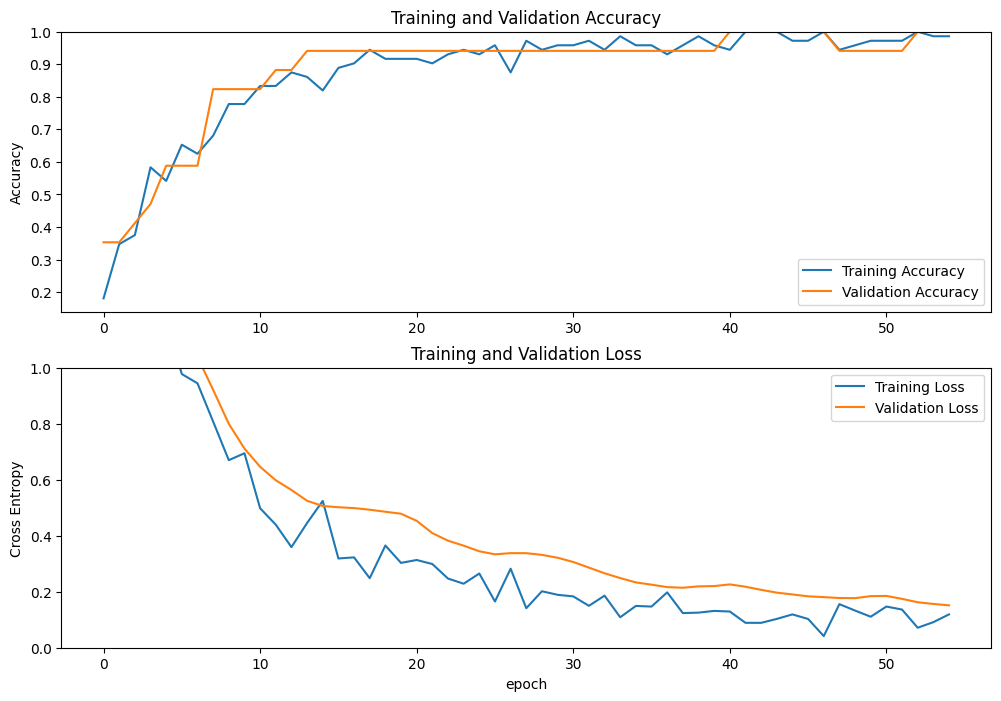

In [112]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# Save the final model
model.save('face_authentication_model.keras')

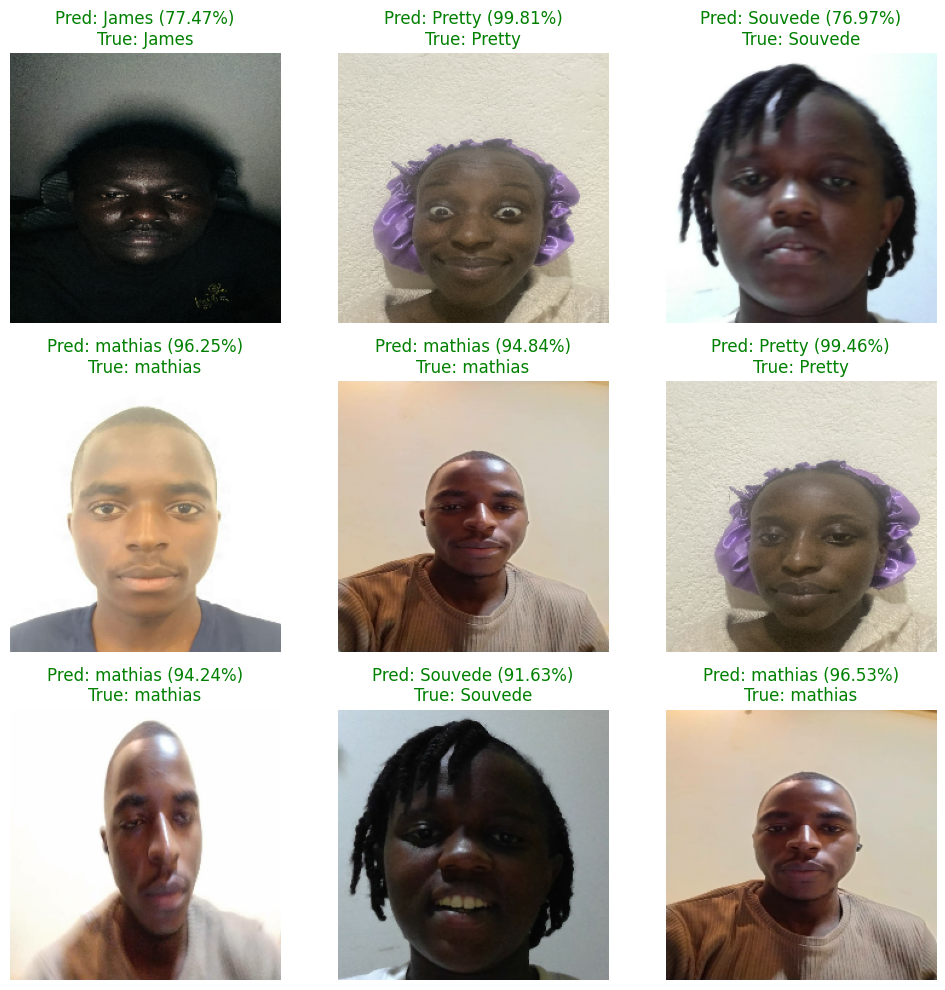

In [113]:
# What to look for:
# *   Are most of the predictions correct (green titles)?
# *   When the model gets it wrong (red titles), what does the image look like? Is it blurry?

# Retrieve a batch of images and labels from the validation dataset
image_batch, label_batch = next(iter(validation_dataset))
# Get the raw predictions from the model (these are logits)
predictions = model.predict_on_batch(image_batch)

# Convert logits to probabilities using a softmax
scores = tf.nn.softmax(predictions)

# Plot the results
plt.figure(figsize=(10, 10))
# Limit the number of images to plot to a maximum of 9
for i in range(min(len(image_batch), 9)): # Iterate up to a maximum of 12 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))

    # The true label - Extract the scalar value from the tensor
    true_label = class_names[label_batch[i].numpy()]
    # The predicted label - Extract the scalar value from the tensor
    predicted_label = class_names[np.argmax(scores[i])]
    # The confidence of the prediction
    confidence = 100 * np.max(scores[i])

    # Set the title color to green for a correct prediction, red for incorrect
    title_color = "green" if predicted_label == true_label else "red"

    plt.title(f"Pred: {predicted_label} ({confidence:.2f}%)\nTrue: {true_label}", color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()




In [114]:
import json

# class_names = train_dataset.class_names # Or however you have your list of names
try:
  class_names = [item.decode('utf-8') for item in class_names]
except AttributeError:
  pass
if not class_names:
  class_names = ['James', 'Pretty', 'Souvede', 'mathias', 'unknown']
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

print("Class names saved to class_names.json")

Class names saved to class_names.json


In [115]:
# Changed MODEL_PATH to the new .keras format
MODEL_PATH = 'face_authentication_model.keras'
CLASS_NAMES_PATH = 'class_names.json'
IMG_HEIGHT = 224
IMG_WIDTH = 224
AUTHENTICATION_THRESHOLD = 90.0  # Require 90% confidence to grant access

def load_model_and_classes():
    """Loads the trained model and class names from disk."""
    try:
        # Custom objects might not be needed with .keras format, but keep for robustness
        custom_objects = {
            'Lambda': Lambda,
            'preprocess_input': tf.keras.applications.mobilenet_v2.preprocess_input
        }
        # Load model from the new .keras file
        model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)
        with open(CLASS_NAMES_PATH, 'r') as f:
            class_names = json.load(f)
        print("Model and class names loaded successfully.")
        return model, class_names
    except Exception as e:
        print(f"Error loading model or class names: {e}")
        print("Please ensure 'face_authentication_model.keras' and 'class_names.json' are in the same directory.")
        sys.exit(1)

def predict_single_image(img_path, model, class_names):
    """
    Loads an image from a file path, preprocesses it, and returns the model's
    top prediction and its confidence score.
    """
    try:
        # Load the image and resize it to the model's expected input size
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    except FileNotFoundError:
        print(f"Error: The file at '{img_path}' was not found.")
        return None, None

    # Convert the image to a NumPy array and add a batch dimension
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    # The model already includes the preprocessing layer, so no need to preprocess here again.
    # Get model predictions (logits)
    predictions = model.predict(img_batch)

    # Convert logits to probabilities using softmax
    scores = tf.nn.softmax(predictions[0])

    # Get the top prediction and its confidence
    predicted_class = class_names[np.argmax(scores)]
    confidence = 100 * np.max(scores)

    return predicted_class, confidence

def run_authentication():
    """Main function to run the interactive authentication script."""
    model, class_names = load_model_and_classes()

    print("\n" + "="*40)
    print("        FACE AUTHENTICATION SYSTEM")
    print("="*40)
    # Check if class_names is not empty before joining
    if class_names:
        print(f"Authorized users: {', '.join(class_names)}")
    else:
        print("No authorized users found.")

    print(f"Required confidence for access: {AUTHENTICATION_THRESHOLD}%")
    print("Type 'exit' to quit.")

    while True:
        # Prompt the user to enter an image path
        image_path = input("\n> Please enter the path to the image for authentication: ")

        if image_path.lower() == 'exit':
            print("Exiting...")
            break

        if not image_path:
            continue

        # Get the prediction
        predicted_name, confidence = predict_single_image(image_path, model, class_names)

        if predicted_name is None:
            continue

        print(f"\n--- Analysis ---")
        print(f"👤 Model prediction: '{predicted_name}'")
        print(f"Confidence: {confidence:.2f}%")
        print("-" * 20)

        # Make the authentication decision
        if confidence >= AUTHENTICATION_THRESHOLD:
            print(f"✅ ACCESS GRANTED. Welcome, {predicted_name}!")
        else:
            print(f"❌ ACCESS DENIED. Confidence is below the {AUTHENTICATION_THRESHOLD}% threshold.")
        print("="*40)


if __name__ == "__main__":
    # Ensure all necessary libraries are installed
    try:
        import tensorflow
        import numpy
        import PIL # Check for Pillow as well
    except ImportError as e:
        print(f"Missing required library: {e.name}. Please run 'pip install tensorflow numpy Pillow'.")
        sys.exit(1)

    run_authentication()

Model and class names loaded successfully.

        FACE AUTHENTICATION SYSTEM
Authorized users: James, Pretty, Souvede, mathias, unknown
Required confidence for access: 90.0%
Type 'exit' to quit.

> Please enter the path to the image for authentication: /content/images/Pretty/pretty_5 copy 2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

--- Analysis ---
👤 Model prediction: 'Pretty'
Confidence: 99.82%
--------------------
✅ ACCESS GRANTED. Welcome, Pretty!

> Please enter the path to the image for authentication: /content/images/mathias/image10.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

--- Analysis ---
👤 Model prediction: 'mathias'
Confidence: 94.49%
--------------------
✅ ACCESS GRANTED. Welcome, mathias!

> Please enter the path to the image for authentication: /content/images/James/IMG_0533.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

--- Analysis ---
👤 Model prediction: 'James'
Confidence: 83.80%
--------------------
❌ ACCESS DENIED. Confidence is below the 90.0% threshold.

> Please en

### Evaluate the model with more metrics

Now that the model is trained, let's evaluate its performance on the validation dataset using metrics like Precision, Recall, F1-score, and a Confusion Matrix.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

       James       1.00      1.00      1.00         1
      Pretty       1.00      1.00      1.00         2
     Souvede       1.00      1.00      1.00         4
     mathias       1.00      1.00      1.00         7
     unknown       1.00      1.00      1.00         3

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



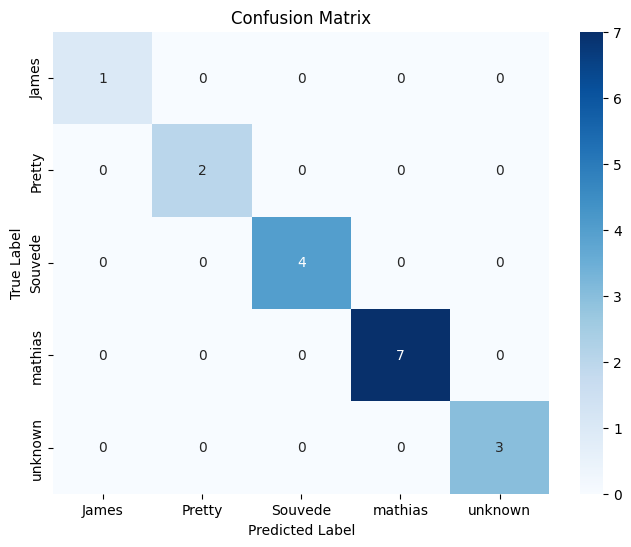

In [116]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get all validation images and labels
all_image_batch = []
all_label_batch = []
for image_batch, label_batch in validation_dataset:
    all_image_batch.append(image_batch.numpy())
    all_label_batch.append(label_batch.numpy())

# Concatenate all batches
all_image_batch = np.concatenate(all_image_batch, axis=0)
all_label_batch = np.concatenate(all_label_batch, axis=0)

# Get predictions for the entire validation dataset
predictions = model.predict(all_image_batch)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = all_label_batch

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()